2025-09-04 15:27:03.822581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756999624.053689      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756999624.119361      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0
Num GPUs Available:  2

Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']

Training data distribution:
{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}

Displaying one sample image from each class...


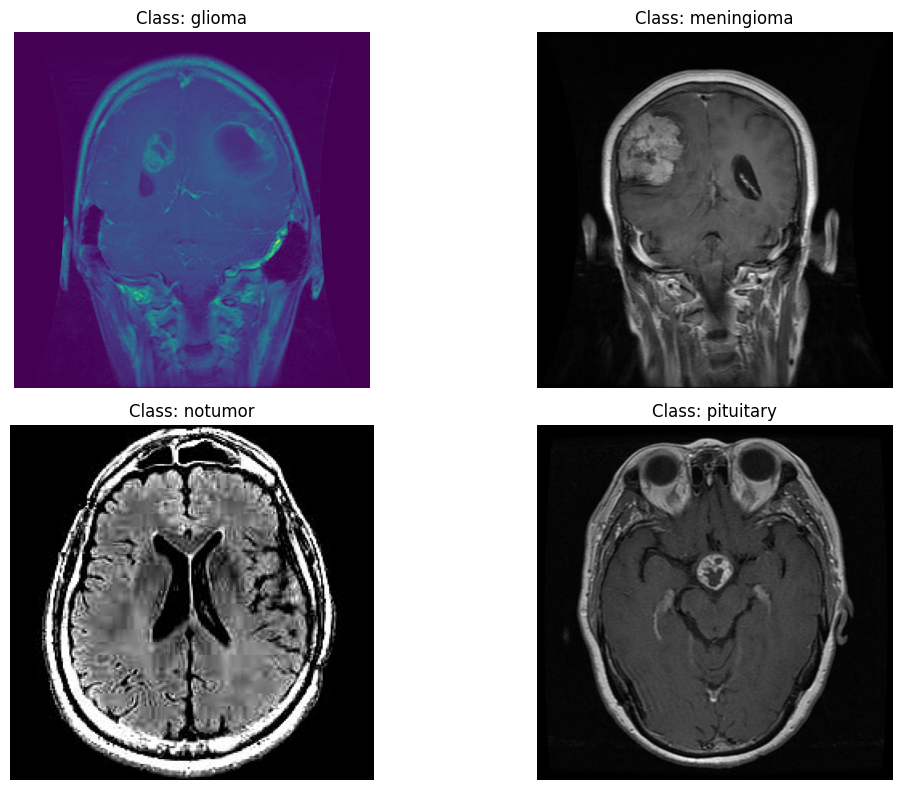

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# --- 1. Confirm GPU is Active ---
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


# --- 2. Define Paths and Explore Data ---
# The main directory containing the 'Training' and 'Testing' folders
data_dir = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = os.path.join(data_dir, 'Training')

# Get the class names from the folders within the training directory
class_names = sorted(os.listdir(train_dir))
print(f"\nClass names: {class_names}")

# Count the number of images in each class
class_distribution = {c: len(os.listdir(os.path.join(train_dir, c))) for c in class_names}
print("\nTraining data distribution:")
print(class_distribution)


# --- 3. Display Sample Images from Each Class ---
print("\nDisplaying one sample image from each class...")
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    # Get a list of all image files in the class directory
    image_files = os.listdir(os.path.join(train_dir, class_name))
    # Pick one random image to display
    sample_image_name = np.random.choice(image_files)
    sample_image_path = os.path.join(train_dir, class_name, sample_image_name)
    
    # Load and display the image
    img = Image.open(sample_image_path)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

# --- 1. Define Constants and Prepare Data Pipeline ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
# The train_dir path was defined in the previous cell
# train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'

# Create the training dataset from the image folders
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

# Create the validation dataset from the same image folders
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

# A layer to randomly flip and rotate images to make the model more robust
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Prefetch data for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)


# --- 2. Build the Model using Transfer Learning ---
# Load the MobileNetV2 model, pre-trained on ImageNet, without its top classification layer
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the pre-trained layers
base_model.trainable = False

# Create our new custom model on top
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs) # Apply augmentation
x = tf.keras.applications.mobilenet_v2.preprocess_input(x) # Preprocess for MobileNetV2
x = base_model(x, training=False) # Run the base model
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x) # Regularization
outputs = layers.Dense(4, activation='softmax')(x) # Final classification layer (4 classes)
model = keras.Model(inputs, outputs)


# --- 3. Compile the Model ---
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of our model's architecture
print("\nModel built and compiled successfully.")
model.summary()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


I0000 00:00:1756999776.254827      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756999776.255557      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model built and compiled successfully.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10


I0000 00:00:1756999831.352660     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.6000 - loss: 0.9840 - val_accuracy: 0.8389 - val_loss: 0.4830
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.8331 - loss: 0.4499 - val_accuracy: 0.8389 - val_loss: 0.4355
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.8609 - loss: 0.3844 - val_accuracy: 0.8616 - val_loss: 0.3853
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.8656 - loss: 0.3549 - val_accuracy: 0.8581 - val_loss: 0.3625
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - accuracy: 0.8787 - loss: 0.3299 - val_accuracy: 0.8669 - val_loss: 0.3499
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.8804 - loss: 0.3151 - val_accuracy: 0.8748 - val_loss: 0.3291
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.8927 - loss: 0.3050 - val_accuracy: 0.8520 - val_loss: 0.3687
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.8884 - loss: 0.3066 - val_accuracy: 0.86

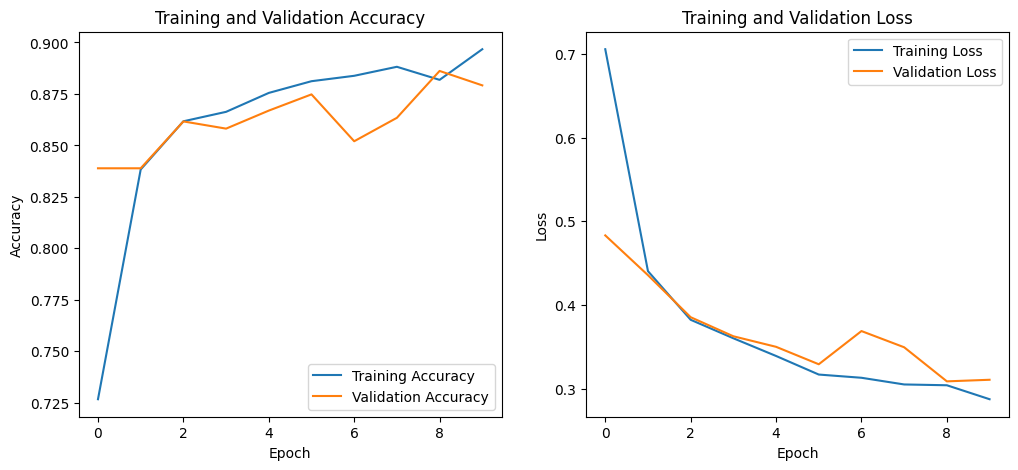

In [3]:
# --- 1. Train the Model ---
# We'll start with 10 epochs, which is a good starting point for transfer learning.
initial_epochs = 10

# The history object will store the model's performance during training
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


# --- 2. Visualize Training Results ---
# Get the accuracy and loss from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Create plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(initial_epochs), acc, label='Training Accuracy')
plt.plot(range(initial_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(initial_epochs), loss, label='Training Loss')
plt.plot(range(initial_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [4]:
# Define the filename for your Keras model
filename = 'brain_tumor_model.keras'

# Save the entire model to a single file
model.save(filename)

print(f"Deep learning model saved successfully as '{filename}'")

Deep learning model saved successfully as 'brain_tumor_model.keras'
